
**Instructions:** Execute the cells sequentially by by pressing shift+enter while selected or clicking the play button on the left. To reset the parameters of a cell, rerun it. Files are saved to this cloud environment and can be accessed through the folder icon on the left.

---

# Introduction

Now that you have some intuition for the analytic 3D PIB solutions from Notebook 1 and the spatial orientation of the $\pi$ electrons in PAHs from Notebook 2, it is time to account for electron-electron interaction in the PIB model through Density-Functional Theory (DFT) using a real-space grid basis. We'll consider each component of the total DFT energy individually in the Kohn-Sham scheme then combine everything into a DFT calculator at the end.

In [4]:
#@title Install/Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'svg'
from scipy import sparse
from IPython.display import Markdown, display, clear_output
import ipywidgets as widgets

!pip install -q ipyvolume==v0.5.1
import ipyvolume as ipv
from google.colab import output
output.enable_custom_widget_manager()

# Background Theory
The justification for performing DFT calculations comes from two theorems by Pierre Hohenberg and Walter Kohn published in 1964. They state, effectively, that <br> 
(1) there is a one-to-one mapping between electron density and external potential and   
(2) a variational principle exists for the electron density. <br>
According to Hohenberg and Kohn instead of solving the Schr&ouml;dinger equation to find the ground state energy, we have a strong theoretical basis for finding it through the density:

$$E[n(r)] = \int n(r) v_{ext}(r) dr + F[n(r)] $$

where is $F$ the unknowable universal functional, $n(r)$ is the electron density, and $v_{ext}(r)$ is the external potential. The Kohn-Sham method of DFT, proposed in 1965, practicalizes these equations by introducing an invented system of noninteracting particles obeying the single-particle Hamiltonian equation 

$$\hat{h}_{KS} \phi_i(r) = \Big[-\frac{1}{2} \nabla_i^2 + v_{ext}(r) + v_{Ha}(r) + v_{XC}(r) \Big] \phi_i(r) = \epsilon_i \phi_i(r).$$

The eigenstate solutions of this equation can be used to find a density that, by its construction, reproduces the exact density of the full-interacting system: 

$$n(r)=2\sum_i |\phi_i(r)|^2.$$ 
The total energy in the KS approach is a functional of the electron density has the form:

$$ E_{tot}[n(r)] = T_s[n(r)] + E_{ext}[n(r)] + E_{Ha}[n(r)] + E_{XC}[n(r)].$$

Now we'll go through the mechanics of each term in KS potential, $\hat{h}_{KS}$, and energy functional, $E[n(r)]$.

## Grid and Kinetic Energy

To start, we'll consider the kinetic energy operator in cartesian coordinates   with atomic units:

$$\hat{T}=-\frac{1}{2}\nabla^2=-\frac{1}{2}\frac{d^2}{dx^2}-\frac{1}{2}\frac{d^2}{dy^2}-\frac{1}{2}\frac{d^2}{dz^2}.$$

The finite difference method provides a numerical way for approximating the 1st, 2nd, 3rd, ... derivatives of functions by evaulating the neighbouring points. For a function $f$ in the x-dimension this would have the form

$$\frac{d^2f _{i,j,k}}{dx^2}=\frac{f _{i+1,j,k}-2f _{i,j,k}+f _{i-1,j,k}}{\Delta x^2}$$

or in a matrix representation

$$\frac{d^2}{dx^2}=\frac{1}{\Delta x^2}\begin{bmatrix}
-2 & 1 & 0 & \dots & 0\\ 
1 & -2 & 1 & \dots & 0 \\
0 & 1 & -2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & -2 \\
\end{bmatrix}$$

$$\rightarrow \hat{T}_x = - \frac{1}{2} \frac{d^2}{dx^2} $$

Each x, y, z component of the kinetic operator is a square matrix in which the number of elements depends on the grid points in that direction. In three dimension the overall operator can be expressed with a kronecker sum:

$$ \hat{T}_{tot} =\hat{T_x}\bigoplus\hat{T_y}\bigoplus\hat{T_z} =
\begin{bmatrix}
[\hat{T}_x]  &       0      &      0      \\
0            & [\hat{T}_y]  &      0      \\
0            &       0      & [\hat{T}_z]  \\
\end{bmatrix}
$$

$\hat{T}_{tot}$ is a diagonally dominant sparse matrix with (grid points)$^2$ entries.

In [39]:
#@title **Kinetic Energy**
lx_slider = widgets.IntSlider(value=12,min=3,max=32,step=1,description='lx',disabled=False,readout_format='d',continuous_update=False)
ly_slider = widgets.IntSlider(value=8,min=3,max=32,step=1,description='ly',disabled=False,readout_format='d',continuous_update=False)
lz_slider = widgets.IntSlider(value=3,min=3,max=32,step=1,description='lz',disabled=False,readout_format='d',continuous_update=False)
length_labels = widgets.Label(value='Box Lengths (Bohr): ')
box_length_ui = widgets.HBox([length_labels, lx_slider, ly_slider, lz_slider],layout=widgets.Layout(border='solid 2px',width='%50'))
num_elect_dropdown = widgets.Dropdown(options=np.arange(2,31,2),value=10,description='electrons:',disabled=False)
k_en_button = widgets.Button(description='Calculate Kinetic Eigenstates',
                             layout=widgets.Layout(width='auto'))
k_en_button.style.font_weight = 'bold'
state_selector = widgets.IntSlider(value=0,min=0,max=50,step=1,description='state',disabled=False,readout_format='d',continuous_update=False)
psi_square_box = widgets.Checkbox(value=False, description='psi square', disabled=False)
density_button = widgets.Button(description='Calculate Density',
                                layout=widgets.Layout(width='auto'))
density_button.style.font_weight = 'bold'

def edge_cleaner(func_3d, nx, ny, nz, num_edges=1):
  func_3d = func_3d.reshape(nx, ny, nz)
  if num_edges == 1:
    func_3d[0,:,:] = 0
    func_3d[-1,:,:] = 0
    func_3d[:,0,:] = 0
    func_3d[:,-1,:] = 0
    func_3d[:,:,0] = 0
    func_3d[:,:,-1] = 0
  elif num_edges == 2:
    func_3d[0,:,:] = 0
    func_3d[-1,:,:] = 0
    func_3d[:,0,:] = 0
    func_3d[:,-1,:] = 0
    func_3d[:,:,0] = 0
    func_3d[:,:,-1] = 0
    func_3d[1,:,:] = 0
    func_3d[-2,:,:] = 0
    func_3d[:,1,:] = 0
    func_3d[:,-2,:] = 0
    func_3d[:,:,1] = 0
    func_3d[:,:,-2] = 0
  return func_3d.flatten()

def integ_3d(func_3d, dx, dy, dz):
  return np.sum(func_3d * dx * dy * dz)

def norm_psi_and_den(e_vecs, occ_states, dx, dy, dz):
  norm_psi = np.zeros_like(e_vecs)
  el_den = np.zeros_like(e_vecs[:,0])
  for i in range(e_vecs.shape[1]):
      norm_psi[:,i] = e_vecs[:,i]/np.sqrt(integ_3d(e_vecs[:,i]**2, dx, dy, dz))
  for i in range(occ_states):
      el_den += 2* norm_psi[:,i]**2
  return norm_psi, el_den

def noninter_kin_e(norm_eigenvecs, occ_states, kin_mat, dx, dy, dz, nx, ny, nz):
  kin_energy_values = []
  for eig in norm_eigenvecs.T[:occ_states]:
    inner_prod = eig*kin_mat.dot(eig)
    inner_prod = edge_cleaner(inner_prod, nx, ny, nz, num_edges=1)
    orbital_k_en = integ_3d(inner_prod, dx, dy, dz)
    kin_energy_values.append(orbital_k_en)
  return sum(kin_energy_values)


def grid_density(l_x, l_y, l_z):
  nx, ny, nz = (5 * l_x), (5 * l_y), (5 * l_z)
  gpoints = (nx * ny * nz)
  xp = np.linspace(0, l_x, nx)
  yp = np.linspace(0, l_y, ny)
  zp = np.linspace(0, l_z, nz)
  X, Y, Z = np.meshgrid(xp, yp, zp, indexing='ij')
  label = '### <center> Grid Points (5 pts/bohr): '
  label += '$x_p \\times y_p \\times z_p ='
  label += f'{nx}' + '\\times' + f'{ny}' + '\\times' + f'{nz}' + ' = '+ f'{gpoints}$ <center/>'
  display(Markdown(label))
  fig1 = ipv.figure(title='PIB',width=450, height=450)
  fig1.camera.type = 'OrthographicCamera'
  ipv.quickscatter(X.flatten(), Y.flatten(), Z.flatten(), size=0.5, marker='box')
  ipv.squarelim()
  ipv.style.box_off()
  ipv.show()

def kin_en_eigenstates(b):
  occ_states = int(num_elect_dropdown.value/2) 
  nextra = 2

  nx, ny, nz = (5 * lx_slider.value), (5 * ly_slider.value), (5 * lz_slider.value)
  xp, yp, zp = np.linspace(0, lx_slider.value, nx), np.linspace(0, ly_slider.value, ny), np.linspace(0, lz_slider.value, nz)

  diag1x = np.ones(nx)/(xp[1])
  diag1y = np.ones(nx)/(yp[1])
  diag1z = np.ones(nx)/(zp[1])

  D1x = sparse.spdiags(np.array([-diag1x, diag1x]), np.array([0,1]), nx, nx)
  D1y = sparse.spdiags(np.array([-diag1y, diag1y]), np.array([0,1]), ny, ny)
  D1z = sparse.spdiags(np.array([-diag1z, diag1z]), np.array([0,1]), nz, nz)

  D1st = sparse.kronsum(D1z,sparse.kronsum(D1y,D1x))

  diagx = np.ones(nx)/(xp[1]**2)
  diagy = np.ones(ny)/(yp[1]**2)
  diagz = np.ones(nz)/(zp[1]**2)

  Dx = sparse.spdiags(np.array([diagx, -2*diagx, diagx]), np.array([-1,0,1]), nx, nx)
  Dy = sparse.spdiags(np.array([diagy, -2*diagy, diagy]), np.array([-1,0,1]), ny, ny)
  Dz = sparse.spdiags(np.array([diagz, -2*diagz, diagz]), np.array([-1,0,1]), nz, nz)

  # construct the sparse matrix 
  T = -1/2 * sparse.kronsum(Dz,sparse.kronsum(Dy,Dx))

  #k will change depnding on number of electrons
  # find the eigenvalues and eigenvectors
  free_p_eval, free_p_evec = sparse.linalg.eigsh(T, k=occ_states+nextra, which='SM',mode='cayley')

  normalized_psi, density = norm_psi_and_den(free_p_evec, occ_states, xp[1], yp[1], zp[1])

  lx_slider.disabled = True
  ly_slider.disabled = True
  lz_slider.disabled = True
  num_elect_dropdown.disabled = True
  k_en_button.disabled = True


  def state_plotter(state_num, psi_square):
    state_selector.max = occ_states + nextra - 1 
    occ_list = 2*np.ones(occ_states)
    occ_list = np.append(occ_list, np.zeros(nextra))

    state_info = f'Orbital Energy, $\epsilon_{state_num}$ = {free_p_eval[state_num]:.3f} Ha'
    state_info += f"   |   'Occupancy': {occ_list[state_num]}"
    display(Markdown(state_info))
    ipv.clear()
    fig2 = ipv.figure(title='Eigenstates',width=450, height=450)
    fig2.camera.type = 'OrthographicCamera'
    if state_num == 0 and not psi_square:
      #pos_values = np.ma.array(normalized_psi.T[state_num].reshape(nx, ny, nz),
      #                         mask = normalized_psi.T[state_num].reshape(nx, ny, nz) < 0.0)
      ipv.pylab.plot_isosurface(normalized_psi.T[state_num].reshape(nx, ny, nz),
                                color='red', #level=pos_values.max()**2,
                                controls=True)
    elif state_num == 0 and psi_square:
      #pos_values = np.ma.array(normalized_psi.T[state_num].reshape(nx, ny, nz),
      #                         mask = normalized_psi.T[state_num].reshape(nx, ny, nz) < 0.0)
      ipv.pylab.plot_isosurface(normalized_psi.T[state_num].reshape(nx, ny, nz)**2,
                          color='red', #level=pos_values.max()**2,
                          controls=True)
    ## isodensity surface
    elif psi_square:
      iso_level = normalized_psi.T[state_num].max()**(7/2)
      ipv.pylab.plot_isosurface(normalized_psi.T[state_num].reshape(nx, ny, nz)**2,
                                color='red', level=iso_level,
                                controls=True)
      
    ## positive and negative isosurfaces
    else:
      #pos_values = np.ma.array(normalized_psi.T[state_num].reshape(nx, ny, nz),
      #                    mask = normalized_psi.T[state_num].reshape(nx, ny, nz) < 0.0)
      #neg_values = np.ma.array(normalized_psi.T[state_num].reshape(nx, ny, nz),
      #              mask = normalized_psi.T[state_num].reshape(nx, ny, nz) > 0.0)
      value_array = normalized_psi.T[state_num].reshape(nx, ny, nz)
      pos_sur = ipv.pylab.plot_isosurface(value_array,
                                          color='red',
                                          level=value_array.max()**(2)*1.5, controls=True)
      neg_sur = ipv.pylab.plot_isosurface(value_array,
                                          color='blue',level=-value_array.max()**(2)*1.5,
                                          controls=True)
    ipv.squarelim()
    ipv.style.box_off()
    ipv.show()



  def plot_inter_density(b):
    density_button.disabled = True
    ipv.clear()
    kin_ener_value = noninter_kin_e(normalized_psi, occ_states, T, xp[1], yp[1], zp[1], nx, ny, nz)
    kin_ener_equation = 'KS Kinetic Energy: '
    kin_ener_equation += '$T_s[n(r)] = - \\frac{1}{2} \sum_i^{N}\langle \phi_i^{KS}(r) |  \\nabla^2|\phi_i^{KS}(r)\\rangle = '
    kin_ener_equation += f'{kin_ener_value:.3f}$ Ha'
    display(Markdown(kin_ener_equation))
    display(Markdown('''If there were no e--e- interaction, this solution
     would be the complete ground-state and this energy would be the total
      energy of the system, directly comparable to 
    the results from notebook 1 in the limit of infinite grid density.'''))
    fig3 = ipv.figure(title='Density',width=450, height=450)
    fig3.camera.type = 'OrthographicCamera'
    ipv.style.box_off()
    ipv.plot_isosurface(density.reshape(nx, ny, nz),
                        color='red',
                        level=density.mean()*2)
    ipv.squarelim()
    ipv.style.box_off()
    ipv.show()
    display(Markdown('isovalue (e/Bohr$^3$)'))

  density_button.on_click(plot_inter_density)


  state_output = widgets.interactive_output(state_plotter, {'state_num': state_selector,
                                                            'psi_square': psi_square_box})
  current_state = state_selector.value
  
  display(state_selector,
          psi_square_box,
          state_output,
          Markdown('isovalue (e/Bohr$^3$)'),
          Markdown('---'),
          Markdown('## Noninteracting Density'),
          Markdown('The occupied Kohn-Sham eigenstates can be used to determine the non-interacting density, $n(r) = 2  \sum_i^{N}|\phi_i^{KS}(r)|^2$, and kinetic energy, $T_s[n(r)] = - \\frac{1}{2} \sum_i^{N}\langle \phi_i^{KS}(r) |  \\nabla^2|\phi_i^{KS}(r)\\rangle$'),
          widgets.HBox([num_elect_dropdown, density_button]))
  
k_en_button.on_click(kin_en_eigenstates)

grid_out = widgets.interactive_output(grid_density, {'l_x': lx_slider,
                                                     'l_y': ly_slider,
                                                     'l_z': lz_slider})

display(Markdown('## Build Discrete Grid'),
        Markdown('''Most DFT codes perform integrals on numerical grids. Below 
        we'll construct a 3D mesh by defining three box lengths and
        allocating 5 grid points per Bohr. The resultant
        grid can be visualized by representing each point as a red cube.'''),
        box_length_ui,
        grid_out,
        Markdown('---'),
        Markdown('## Kinetic Energy Eigenstates'),
        Markdown('''With the above defined grid,
        we can write a matrix that represents kinetic energy 
        acting on functions represted on this grid, . The eigenvalues 
        and eigvectors of this matrix represent.'''),
        Markdown('$\hat{T}_{tot} = \hat{T}_z\\bigoplus\hat{T}_y\\bigoplus\hat{T}_z \\xrightarrow[\\text{linalg.eigsh}]{\\text{scipy}} |\phi_i(r)\\rangle,\ \epsilon_i$'),
        widgets.HBox([num_elect_dropdown,k_en_button])
)

## Build Discrete Grid

Most DFT codes perform integrals on numerical grids. Below 
        we'll construct a 3D mesh by defining three box lengths and
        allocating 5 grid points per Bohr. The resultant
        grid can be visualized by representing each point as a red cube.

Output()

---

## Kinetic Energy Eigenstates

With the above defined grid,
        we can write a matrix that represents kinetic energy 
        acting on functions represted on this grid, . The eigenvalues 
        and eigvectors of this matrix represent.

$\hat{T}_{tot} = \hat{T}_z\bigoplus\hat{T}_y\bigoplus\hat{T}_z \xrightarrow[\text{linalg.eigsh}]{\text{scipy}} |\phi_i(r)\rangle,\ \epsilon_i$

IntSlider(value=0, continuous_update=False, description='state', max=6)

Checkbox(value=False, description='psi square')

Output()

isovalue (e/Bohr$^3$)

---

## Noninteracting Density

The occupied Kohn-Sham eigenstates can be used to determine the non-interacting density, $n(r) = 2  \sum_i^{N}|\phi_i^{KS}(r)|^2$, and kinetic energy, $T_s[n(r)] = - \frac{1}{2} \sum_i^{N}\langle \phi_i^{KS}(r) |  \nabla^2|\phi_i^{KS}(r)\rangle$

KS Kinetic Energy: $T_s[n(r)] = - \frac{1}{2} \sum_i^{N}\langle \phi_i^{KS}(r) |  \nabla^2|\phi_i^{KS}(r)\rangle = 3.427$ Ha

If there were no e--e- interaction, this solution
     would be the complete ground-state and this energy would be the total
      energy of the system, directly comparable to 
    the results from notebook 1 in the limit of infinite grid density.

isovalue (e/Bohr$^3$)

# LDA Exchange

The simplest approach to electronic exchange
is the Local Density Approximation (LDA), whereby the exchange
energy per particle at each point in space is assumed to be equal to that of 
a uniform electron gas (UEG) with the same density. The LDA exchange potential has a
concise form found by Dirac in 1930: \\
\
$$ v_X^{LDA}(n(r)) = -\frac{3}{4}\left(\frac{3}{\pi}\right)^{1/3} n(r)^{1/3} .$$
\
This potential can be integrated against the density to yield the total
exchange energy,
$ E_X^{LDA}[n(r)] = \int{v_X^{LDA}(n(r))n(r)} dr .$
The LDA is a local functional in the sense that it only depends on the 
value of the density at each point (grid point in our case), as opposed to 
the integrals over all space required for Hartree-Fock exchange.


In [ ]:
#@title **Exchange Diagram**
LDA_exch_slider = widgets.FloatSlider(description='n(r)', min=0.00, max=2, step=0.05,
                                      continuous_update=False)

def exch_equation(den_number):
  exch_pot_number = np.round(-(3/4)*(3/np.pi)**(1/3)*den_number**(1/3), decimals=3)
  text = Markdown('## $v_{X,\ n(r)= \ ' + f'{den_number:.2f}' + '}^{LDA} = -\\frac{3}{4}' +
                       '\left(\\frac{3}{\pi}\\right)^{1/3}' + 
                       f'({den_number:.2f})' + '^{1/3}' +
                       f'={exch_pot_number:.3f}\ ' + '\\text{Ha/e}$')
  
  display(text)
  clear_output(wait=True)



def exch_pot_eq(den_number):
  exch_pot_number = np.round(-(3/4)*(3/np.pi)**(1/3)*den_number**(1/3), decimals=3)
#  text = Markdown('## $v_{X,\ n(r)= \ ' + f'{den_number:.2f}' + '}^{LDA} = -\\frac{3}{4}' +
#                       '\left(\\frac{3}{\pi}\\right)^{1/3}' + 
#                       f'({den_number:.2f})' + '^{1/3}' +
#                       f'={exch_pot_number:.3f}\ ' + '\\text{Ha/e}$')
#  
#  display(text)
  
  display(Markdown('<br>'))
  x = np.linspace(0, 10, 300)
  y = np.round(-(3/4)*(3/np.pi)**(1/3)*x**(1/3), decimals=3)
  
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.cla()
  plt.clf()
  clear_output(wait=True)
  plt.plot(x, y, label=r'Slater exchange')
  plt.hlines(exch_pot_number, 0, den_number, colors='black')
  plt.vlines(den_number, -2, exch_pot_number, colors='black')
  plt.scatter(den_number, exch_pot_number, marker="s", color='red', label='grid point')
  plt.title('LDA Exchange Potential', size=15)
  plt.xlabel('Density, $n(r)$', size=15)
  plt.ylabel('Potential, $v_X^{LDA}(n(r))$', size=15)
  plt.xlim(0,2)
  plt.ylim(-1.25,0)
  plt.rcParams["legend.markerscale"] = 1.5
  plt.legend(loc='upper right', fontsize=15)
  plt.show()
  


LDA_exc_output = widgets.interactive_output(exch_pot_eq, {'den_number':LDA_exch_slider})
equation_output = widgets.interactive_output(exch_equation, {'den_number':LDA_exch_slider})

display(LDA_exch_slider,
        equation_output,
        LDA_exc_output)

FloatSlider(value=0.0, continuous_update=False, description='n(r)', max=2.0, step=0.05)

Output()

Output()

# LDA Corrrelation
The correlation energy from a UEG
does not have an exact form applicable to densities in the intermediate regime
and fitted parameterizations tend to be very complicated. However, an 
expression found by Chachiyo in 2016 with only two fitting parameters that accurately reproduces the UEG results does have a simple, elegant form:
\
$$v_{c}^{LDA}(r_s)= a\cdot ln\left(1+\frac{b}{r_s}+\frac{b}{r_s^2}\right)$$
where $a = \frac{ln2-1}{2\pi^2}$, $b \approx 20.4562557$, and $r_s$ is the
desnity-dependent Wigner-sitz radius,
$r_s = \left(\frac{3}{4\pi n(r)}\right)^{1/3}$. $r_s$ is proportional to the inverse cube root of the density and has the following limits: <br>
low-density, $n(r) \rightarrow 0 \Longrightarrow r_s \rightarrow \infty $ <br>
high-density,  $n(r) \rightarrow \infty \Longrightarrow r_s \rightarrow 0 $.



In [ ]:
#@title **Correlation Diagram**
LDA_cor_slider = widgets.FloatSlider(description='r_s', min=0.01, max=10, step=0.01,
                                      continuous_update=False)
def LDA_c_display(ws_radius):
    a, b, c = (np.log(2)-1)/(2*np.pi**2), 20.4562557, (4*np.pi/3)**(1/3)
    lda_expression = lambda rad: a*np.log(1 + b*c*1/(rad) + b*(c**2)*1/(rad))
    cor_pot_number = lda_expression(ws_radius)
    text = Markdown('## $v_{c,\ r_s=' + f'{ws_radius:.2f}' + '}^{LDA}' + '= a\cdot ln\left(1+\\frac{b}{' +
                  f'({ws_radius:.2f})' + '} + \\frac{b}{' + f'({ws_radius:.2f})^2' + 
                  '}\\right)=' + f'{cor_pot_number:.3f}\ ' + '\\text{Ha/e}$')
    display(text)
    x = np.linspace(0.001, 10, 100)
    y = lda_expression(x)

    plt.plot(x, y, label='Chachiyo Correlation')
    plt.scatter(ws_radius, cor_pot_number, color='red', marker="s", label='grid point')
    plt.hlines(cor_pot_number, 0, ws_radius, colors='black')
    plt.vlines(ws_radius, -2, cor_pot_number, colors='black')
    plt.title('LDA Correlation Potential', size=15)
    plt.xlabel('Wigner-Seitz Radius, $r_s$', size=15)
    plt.ylabel('Potential, $v_c^{LDA}(r_s)$', size=15)
    plt.xlim(0,10)
    plt.ylim(-0.15,0)
    plt.rcParams["legend.markerscale"] = 1.5
    plt.legend(loc='upper right', fontsize=15)
    plt.show()

output = widgets.interactive_output(LDA_c_display, {'ws_radius':LDA_cor_slider})

display(LDA_cor_slider, output)

FloatSlider(value=0.01, continuous_update=False, description='r_s', max=10.0, min=0.01, step=0.01)

Output()

# PBE Exchange

Another approximate approach to exchange-correlation functionals is the Generalized Gradient Approximation (GGA), which incorporates information about not only about the density at each point in space but also
the gradient, or 1st derivative. The most popular GGA nowadays was reported in a 1996
paper by Perdue, Burke, and Enzerhof and is acronymized as PBE. The electronic
exchange potential in PBE is defined relative to LDA exchange: \\
\
$$ v_X^{PBE}(n(r),s) = v_x^{LDA}(n(r))F_x(s) $$
\
where the $F_x(s)$ term is an exchange enhancement factor that has the form \
\
$$F_x(s)= 1+ \kappa -\frac{\kappa}{\left(1+\frac{\mu s^2}{\kappa}\right)}.$$ \

$F_x(s)$ depends on two constants, $\kappa = 0.804$ and $\mu \approx 0.21951 $, and the unitless reduced density gradient (RDG), \\
\
$$s = \frac{|\nabla{n(r)}|}{2(3)^{1/3}\pi^{2/3}n(r)^{4/3}} .$$


In [ ]:
#@title **Exchange Diagram**
GGAx_den_slider = widgets.FloatSlider(description='n(r)', min=0.05, max=1, step=0.05,
                                      continuous_update=False)
GGAx_grad_slider = widgets.FloatSlider(description='|grad n(r)|', min=0.01, max=2, step=0.05,
                                      continuous_update=False)


def GGAx_pot_eq(den_num, grad_den_num):
  kappa = 0.804
  mu = 0.21951
  calculate_s = lambda den, grad_den: abs(grad_den)/(2*3**(1/3)*np.pi**(2/3)*den**(4/3))
  calculate_F_s = lambda s: 1 + kappa - kappa/(1 + mu*s**2 / kappa)

  s_num = calculate_s(den_num, grad_den_num)
  F_s_num = calculate_F_s(s_num)

  equation = '## $s = \\frac{' + f'|{grad_den_num:.3f}|' + '}{2\cdot3' + '^{1/3}\pi^{2/3}' + f'({den_num:.3f})' + '^{4/3}}=' + f'{s_num:.3f}\ '
  equation += '\ \ \ \ F_{x,\ s=' + f'{s_num:.3f}' + '} = 1 + \kappa - \\frac{\kappa}{(1+\\frac{\mu' + f'({s_num:.3f})^2' + '}{\kappa})}=' + f'{F_s_num:.3f}\ ' + '$'

  equation = Markdown(equation)

  display(equation)
  display(Markdown('<br>'))
  x_s = np.linspace(0, 10, 300)
  y = calculate_F_s(x_s)
  
  plt.plot(x_s, y, label=r'PBE Exch. Factor')
  plt.hlines(F_s_num, 0, s_num, colors='black')
  plt.vlines(s_num, -2, F_s_num, colors='black')
  plt.scatter(s_num, F_s_num, color='red', marker="s", label='grid point')
  plt.title('GGA Enchancement Factor', size=15)
  plt.xlabel('RDG, $s$', size=15)
  plt.ylabel('$F_X(s)$', size=15)
  plt.xlim(0,10)
  plt.ylim(0.95, 2.1)
  plt.legend(loc='upper left', fontsize=15)
  plt.show()

GGA_ex_output = widgets.interactive_output(GGAx_pot_eq, {'den_num':GGAx_den_slider,
                                                         'grad_den_num':GGAx_grad_slider})

sliders = widgets.HBox([GGAx_den_slider, GGAx_grad_slider])

display(sliders,
        GGA_ex_output)



Output()

# PBE Correlation
Unfortunately, the equations for PBE correlation
are nonintuitive and contains various constants: \
\
$$v_c^{PBE}(r_s, t) = v_{c}^{LDA}(r_s) + H(r_s, t)$$ 
\
$$H(r_s, t) = \gamma\ln\Big[1+\frac{\beta}{\gamma}t^2\Big(\frac{1+At^2}{1+At^2+A^2t^4}\Big)\Big]$$ \
\
$$ A = \frac{\beta}{\gamma}\Big[\text{exp} \Big\{ \frac{-v_c^{LDA}}{\gamma \phi^3e^2/a_0} \Big\} - 1 \Big]^{-1} $$ 
\
$$ t = \frac{|\nabla n(r)|\pi^{1/6}}{4(3)^{1/6}n(r)^{7/6}} $$ \\
What is clear from the above terms is that PBE correlation is defined relative to LDA correlation and is an energy functional of the density. Therefore, given a density and its derivatives the energy from PBE correlation can be calculated determined,
$E[n(r), \nabla n(r)] = \int{[v_{c}^{LDA}(r_s) + H(r_s, t)]n(r)dr} .$



## Hartree Potential
The hartree potential, which is a classical potential 
that a charge distribution experiences with itself due to coulomb's law,
has the expression\
\
$$ v_{Ha}(n(r)) = \int{\frac{n(r')}{|r-r'|}drdr'}.$$ \
This program forgoes the memory-intensive task of directly evaulating this integral
by instead solving Poisson's equation through a Conjuagte Gradient
Ax = b matrix eqation solver in scipy given a density, $n(r)$, and finite-difference
representation of $\nabla^2$: \
\
$$ \nabla^2v_{Ha}(r)=-4\pi n(r) .$$ \
$v_{Ha}(r)$ can be integrated to yield the (positive) Hartree repulsion Energy with a factor of 1/2 to avoid double counting electrons, $E_{Ha}[n(r)]=\frac{1}{2}\int{v_{Ha}(r)n(r)dr}$. As an example, consider the 1D charge distribution described by
a trigonometric function with some frequency defined from 0 to 2$\pi$.


In [ ]:
#@title **Hartree Potential** 
freq_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, 
                                description='freq', disabled=False, readout_format='d', 
                                continuous_update=False)

def hartree_plotter(freq, solve_poisson):
  nx = 300
  x = np.linspace(0, np.pi, nx)
  y = np.sin(freq*x)**2

  diag1x = np.ones(nx)/(x[1])
  D1x = sparse.spdiags(np.array([-diag1x, diag1x]), np.array([0,1]), nx, nx)
  diagx = np.ones(nx)/(x[1]**2)
  D2x = sparse.spdiags(np.array([diagx, -2*diagx, diagx]), np.array([-1,0,1]), nx, nx)
  T = -1/2 * D2x
  test = sparse.linalg.cg(-2*T, -4.*np.pi*y)
  

  derivative1 = D1x.dot(y)
  derivative2 = D2x.dot(y)

  equation1 = '## $n(x) = sin^2( 2 \pi ' + f'({freq})' + 'x)$'
  equation2 = '## $\\nabla^2V(x)=-4\pi n(x) \\xrightarrow[\\text{linalg.cg}]{\\text{scipy}} V(x)$'
  display(Markdown(equation1))
  display(Markdown(equation2))
  plt.gcf()
  plt.clf()
  plt.title('1D Hartree Potential', size=15)
  plt.plot(x, y, label=f'n(x)=$sin^2(2 \pi ({freq}) x)$')
  if solve_poisson:
    plt.plot(x, test[0], label='V(x)')
  plt.xlabel('x', size=15)
  plt.ylabel('Amplitude', size=15)
  plt.legend(loc='upper right')
  plt.grid()
  plt.show()

  print()

hartree_output = widgets.interactive_output(hartree_plotter, {'freq': freq_slider,
                                                              'solve_poisson': widgets.fixed(True)})

display(freq_slider,
        hartree_output)

IntSlider(value=1, continuous_update=False, description='freq', max=10, min=1)

Output()

# Putting Everything Together

With the above definitions we can define an effective **single-particle
hamiltonian** with kinetic, exchange, correlation, 
and Hartree components. This operator will depend on the input density and can be solved with scipy's sparse.linalg.eigsh eigenvalue solver, yielding eigenvalues and eigenvectors corresponding to a new output density, which can then be used to define a new hamiltonian that can be solved to produce another density, and so on. This cylce of  will continue until (1) the maximum number of iterations is reached or (2) the energy **convergence threshold** is met, whereby the energy associated with the input and output densities are said to be the same. The input density to these equations at iteration #0 will be the 
non-interacting density from the 3D PIB solutions and the final converged density will be optimized according to the Kohn-Sham scheme. Below is a table of ____. 


PAH|Rings|Dimensions (Bohr)| $ \pi $ electrons|Fuse-type
:---:|:---:|:---:|:---:|:---:
benzene   |1|   8 x 8 x 3  | 6  |linear
napthalene|2|  12 x 8 x 3 | 10 |linear
anthracene|3|  16 x 8 x 3 | 14 |linear
tetracene |4|  20 x 8 x 3 | 18 |linear
pentacene |5|  24 x 8 x 3 | 22 |linear
hexacene  |6|  28 x 8 x 3 | 26 |linear
heptacene |7|  32 x 8 x 3 | 30 |linear
---       |---|---        |--- |---
perylene  |5| 20 X 12 x 3 | 20 | non-linear
coronene  |7| 20 X 16 x 3 | 24 | non-linear

To ensure stable convergence behavior, an energy threshold of 10$^{-4}$ Ha and 70/30 **density mixing** is reccomended. Density mixing refers to mixing in some fraction of density from the previous iteration to define the new density. A 70/30 linear mixture translates to mixing 70% of the density generated at iteration number $i$ with 30% at iteration $i-1$ to yield a new composite density for iteration $i+1$:
\
$$ n_{i+1}(r) = 0.7n_i(r) + 0.3n_{i-1}(r) .$$ 

As a **word of caution**, PBE can become numerically unstable on the grids considered here, particuarly with perfect cubical symmetry.

## <center> Single Particle Hamiltonian <center/> 

Output()

<br>

<br>

<br>

<br>

<br>

---

,#i,-E_tot-,delta_E,--E_KE-,--E_x--,--E_c--,--E_ha-


,00,3.28041,3.28041,3.28041,0.00000,0.00000,0.00000


,01,3.62345,0.34304,3.46411,-2.81761,-0.46930,3.44625


,02,3.32899,-0.29446,3.39989,-2.75569,-0.46483,3.14962


,03,3.19533,-0.13367,3.37261,-2.73026,-0.46291,3.01589


,04,3.12987,-0.06545,3.36047,-2.71738,-0.46191,2.94870


,05,3.09573,-0.03415,3.35474,-2.70990,-0.46133,2.91222


,06,3.07708,-0.01865,3.35192,-2.70522,-0.46097,2.89135


,07,3.06653,-0.01054,3.35049,-2.70220,-0.46073,2.87898


,08,3.06040,-0.00613,3.34975,-2.70021,-0.46058,2.87144


,09,3.05675,-0.00365,3.34936,-2.69889,-0.46048,2.86676


,10,3.05453,-0.00222,3.34915,-2.69800,-0.46041,2.86379


,11,3.05316,-0.00137,3.34903,-2.69741,-0.46036,2.86189


,12,3.05229,-0.00086,3.34897,-2.69700,-0.46033,2.86066


,13,3.05174,-0.00055,3.34893,-2.69673,-0.46031,2.85985


,14,3.05139,-0.00035,3.34891,-2.69655,-0.46030,2.85932


,15,3.05116,-0.00023,3.34890,-2.69642,-0.46029,2.85897


,16,3.05101,-0.00015,3.34889,-2.69633,-0.46028,2.85873


,17,3.05091,-0.00010,3.34889,-2.69628,-0.46028,2.85857


   
Converged!
delta E = 0.000099 < 0.000100
HOMO-LUMO Gap is 0.13435 Ha (3.656 eV)
Final energy of 3.05091 Ha reached in 17 iterations


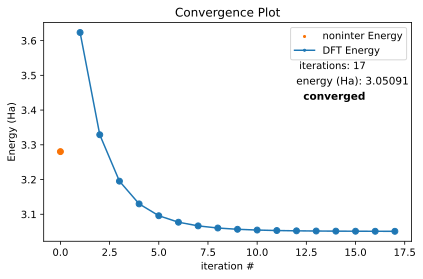

In [44]:
#@title **DFT Calculator**

def hamiltonian_display(functional, har, ex, cor):
  ham = '## $$ \hat{h}_i = \hat{T}_{kin, i} +'
  if har == True:
    ham += 'v_{Ha}(n(r))'
  else: 
    ham += '0'
  if ex == True:
    if functional == 'LDA':
      ham += '+ v_{x}^{LDA}(n(r))'
    elif functional == 'PBE':
      ham += '+ v_{x}^{PBE}(n(r), \\nabla n(r))'
  else: 
    ham += '+ 0'
  if cor == True:
    if functional == 'LDA':
      ham += '+ v_{c}^{LDA}(n(r))'
    elif functional == 'PBE':
      ham += '+ v_{c}^{PBE}(n(r), \\nabla n(r))'
  else:
    ham += '+ 0'
  ham += '$$'
  display(Markdown(ham))

length_labels = widgets.Label(value='Box Lengths (Bohr): ')
lx_slider_dft = widgets.IntSlider(value=12,min=3,max=32,step=1,description='lx',disabled=False,readout_format='d',continuous_update=False)
ly_slider_dft = widgets.IntSlider(value=8,min=3,max=32,step=1,description='ly',disabled=False,readout_format='d',continuous_update=False)
lz_slider_dft = widgets.IntSlider(value=3,min=3,max=32,step=1,description='lz',disabled=False,readout_format='d',continuous_update=False)

functional_dropdown = widgets.Dropdown(options=[('LDA', 'LDA'), ('PBE (GGA)', 'PBE')],
                                       value='LDA',
                                       description='Fuctional:',
                                       disabled=False,
                                       layout = widgets.Layout(width='200px'))
hartree_dropdown = widgets.Dropdown(options=[('On', True), ('Off', False)],
                                       value=True,
                                       description='Hartree:',
                                       disabled=False,
                                       layout = widgets.Layout(width='175px'))
exchange_dropdown = widgets.Dropdown(options=[('On', True), ('Off', False)],
                                       value=True,
                                       description='Exchange:',
                                       disabled=False,
                                       layout = widgets.Layout(width='175px'))
correlation_dropdown = widgets.Dropdown(options=[('On', True), ('Off', False)],
                                       value=True,
                                       description='Correlation:',
                                       disabled=False,
                                       layout = widgets.Layout(width='175px'))
num_elec_label = widgets.Label(value='Number Electrons: ')
num_elec_dropdown = widgets.Dropdown(options=np.arange(2, 31, 2), 
                                    value=10, description=' ',
                                    disabled=False,
                                     layout = widgets.Layout(width='175px'))

converge_parameter_label = widgets.Label(value='Convergence Settings: ')
max_iter_dropdown = widgets.Dropdown(options=np.arange(5, 105, 5), 
                                    value=30, description='max iter',
                                    disabled=False,
                                     layout = widgets.Layout(width='150px'))
density_mix_dropdown = widgets.Dropdown(options=['OFF', '50/50', '60/40', '70/30', '80/20', '90/10'],
                                       value='70/30',
                                       description='density mix: ',
                                       disabled=False,
                                       layout = widgets.Layout(width='200px'))
e_tol_dropdown = widgets.Dropdown(options=['-3', '-4', '-5', '-6'],
                                       value='-4',
                                       description='energy tol (10^ Ha): ',
                                       disabled=False,
                                       layout = widgets.Layout(width='200px'),
                                        style = {'description_width': 'initial'})

filename_text = widgets.Text(description='Filename (.png): ',value='energy_log',style={'description_width': 'initial'})
save_button = widgets.Button(description='Save Image')

den_filename_text = widgets.Text(description='Filename (.png): ',value='density_slice',style={'description_width': 'initial'})
den_save_button = widgets.Button(description='Save Image')

orbital_filename_text = widgets.Text(description='Filename (.png): ',value='orbital_energies',style={'description_width': 'initial'})
orbital_save_button = widgets.Button(description='Save Image')

run_scf_button = widgets.Button(description='Run SCF')
run_scf_button.style.font_weight = 'bold'
reset_button = widgets.Button(description='Reset')

density_analysis_button = widgets.Button(description='Analyze Density')
run_scf_button.style.font_weight = 'bold'

side_select = widgets.SelectionSlider(
options=['lx', 'ly', 'lz'],
    value='lx',
    description='box side: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

scf_ui = widgets.HBox([run_scf_button, reset_button])
box_length_iso_ui = widgets.HBox([length_labels, lx_slider_dft, ly_slider_dft, lz_slider_dft])
parameter_ui = widgets.HBox([num_elec_label, num_elec_dropdown])

ham_ui = widgets.HBox([functional_dropdown, hartree_dropdown,
                       exchange_dropdown, correlation_dropdown])
convergence_ui = widgets.HBox([converge_parameter_label, max_iter_dropdown,
                               density_mix_dropdown, e_tol_dropdown])

output = widgets.interactive_output(hamiltonian_display, {'functional':functional_dropdown,
                                                 'har':hartree_dropdown,
                                                 'ex':exchange_dropdown,
                                                 'cor':correlation_dropdown})

energy_log = [0] #zero neede for first difference; removed after end of for loop
ener_diff_log = []
converged = None
exch_log = []
cor_log = []
har_log = []
kin_log = []
eigenvalue_log = []
eigenstate_log = []
density_log = [] 
grid_points = []
grid_lines = []

def energy_plot(den_log, ener_log, converge_state, show_fig=True, save_fig=False, filename=None):
  fig = plt.figure(figsize=(6, 4))
  ax = fig.add_subplot(1, 1, 1)
  plt.title('Convergence Plot')
  plt.scatter(0, energy_log[0], color='#F97306', label='noninter Energy')
  plt.plot(np.arange(1,len(energy_log[1:]) + 1), energy_log[1:], 'o-', label='DFT Energy')
  plt.legend(loc='upper right')
  plt.text(0.785, 0.800, f'iterations: {len(density_log) - 1}',
          horizontalalignment='center', verticalalignment='center',
          transform=ax.transAxes)
  plt.text(0.785, 0.730,f'            energy (Ha): {energy_log[-1]:.5f}',
          size=10.5, horizontalalignment='center', verticalalignment='center',
          transform= ax.transAxes)
  if converge_state == True:
    plt.text(0.79, 0.660,f'converged',
            size=10.5, horizontalalignment='center', verticalalignment='center',
            transform= ax.transAxes, weight='bold')
  elif converge_state == False:
    plt.text(0.79, 0.660,f'unconverged',
            size=10.5, horizontalalignment='center', verticalalignment='center',
            transform= ax.transAxes, weight='bold')
  plt.ylabel('Energy (Ha)')
  plt.xlabel('iteration #')
  plt.tight_layout()
  if save_fig:
    plt.savefig(f'{filename}.png', dpi = 800)
  if show_fig:
    plt.show()
  else:
    plt.close()

filename_text = widgets.Text(description='Filename (.png): ',value='energy_log',style={'description_width': 'initial'})
save_button = widgets.Button(description='Save Image')

def edge_cleaner(func_3d, nx, ny, nz, num_edges=1):
  func_3d = func_3d.reshape(nx, ny, nz)
  if num_edges == 1:
    func_3d[0,:,:] = 0
    func_3d[-1,:,:] = 0
    func_3d[:,0,:] = 0
    func_3d[:,-1,:] = 0
    func_3d[:,:,0] = 0
    func_3d[:,:,-1] = 0
  elif num_edges == 2:
    func_3d[0,:,:] = 0
    func_3d[-1,:,:] = 0
    func_3d[:,0,:] = 0
    func_3d[:,-1,:] = 0
    func_3d[:,:,0] = 0
    func_3d[:,:,-1] = 0
    func_3d[1,:,:] = 0
    func_3d[-2,:,:] = 0
    func_3d[:,1,:] = 0
    func_3d[:,-2,:] = 0
    func_3d[:,:,1] = 0
    func_3d[:,:,-2] = 0
  return func_3d.flatten()

def hard_walls(potential, nx, ny, nz):
  potential = potential.reshape(nx, ny, nz)
  potential[0,:,:]  = 1000
  potential[-1,:,:] = 1000
  potential[:,0,:]  = 1000
  potential[:,-1,:] = 1000
  potential[:,:,0]  = 1000
  potential[:,:,-1] = 1000
  return potential.flatten()

def integ_3d(func_3d, dx, dy, dz):
  return np.sum(func_3d * dx * dy * dz)

def norm_psi_and_den(e_vecs, occ_states, dx, dy, dz):
  norm_psi = np.zeros_like(e_vecs)
  el_den = np.zeros_like(e_vecs[:,0])
  for i in range(e_vecs.shape[1]):
      norm_psi[:,i] = e_vecs[:,i]/np.sqrt(integ_3d(e_vecs[:,i]**2, dx, dy, dz))
  for i in range(occ_states):
      el_den += 2* norm_psi[:,i]**2
  return norm_psi, el_den

def noninter_kin_e(norm_eigenvecs, occ_states, kin_mat, dx, dy, dz, nx, ny, nz):
  kin_energy_values = []
  for eig in norm_eigenvecs.T[:occ_states]:
    inner_prod = eig*kin_mat.dot(eig)
    inner_prod = edge_cleaner(inner_prod, nx, ny, nz, num_edges=1)
    orbital_k_en = integ_3d(inner_prod, dx, dy, dz)
    kin_energy_values.append(orbital_k_en)
  return sum(kin_energy_values)

def hartree(den, kin_oper, dx, dy, dz, nx, ny, nz):
  clean_den = np.ma.array(den, mask= abs(den) < 0.000001)
  clean_den = np.ma.filled(clean_den, fill_value=0.0)
  den = clean_den
  den = edge_cleaner(den, nx, ny, nz, num_edges=1)
  v_ha_flat = sparse.linalg.cg(-2*kin_oper,-4.*np.pi*den)[0]
  v_ha_flat = edge_cleaner(v_ha_flat, nx, ny, nz, num_edges=1)
  v_ha_ener = (1/2)*integ_3d(v_ha_flat*den, dx, dy, dz)
  return v_ha_flat, v_ha_ener

def lda_exchange(den, dx, dy, dz):
  exch_pot_lda = -(3/4)*(3/np.pi)**(1/3)*(den)**(1/3)
  clean_den = np.ma.array(den, mask= abs(den) < 0.000001)
  clean_den = np.ma.filled(clean_den, fill_value=0.0)
  den = clean_den
  exch_ener_lda = -(3/4)*(3/np.pi)**(1/3)*integ_3d(den**(4/3), dx, dy, dz)  
  return exch_pot_lda, exch_ener_lda

def lda_correlation(den, dx, dy, dz):
    ### paper: 10.1063/1.4958669
    a = (np.log(2)-1)/(2*np.pi**2)
    b = 20.4562557
    c = (4*np.pi/3)**(1/3)
    corr_pot = a*np.log(1 + b*c*den**(1/3) + b*(c**2)*den**(2/3))
    clean_den = np.ma.array(den, mask= abs(den) < 0.000001)
    clean_den = np.ma.filled(clean_den, fill_value=0.0)
    den = clean_den
    corr_en = integ_3d(den*corr_pot, dx, dy, dz)
    return corr_pot, corr_en

def RDG(den, der_1st, nx, ny, nz):
  clean_den = np.ma.array(den, mask = abs(den) < 0.000001)
  den = clean_den
  RDG = (2*3**(1/3)*np.pi**(2/3))**(-1) * abs(der_1st.dot(den)) * den**(-4/3)
  RDG = edge_cleaner(RDG, nx, ny, nz, num_edges=1)
  RDG = np.ma.filled(RDG, fill_value=0.0)
  return RDG

def pbe_exchange(den, D1st, dx, dy, dz, nx, ny, nz):
    ### paper: 10.1103/PhysRevLett.77.3865
    kappa = 0.804
    mu = 0.2195149727645171
    s = RDG(den, D1st, nx, ny, nz)
    F_xs = 1 + kappa - kappa * (1 + mu * s**2 / kappa)**(-1)
    exch_pot_pbe = F_xs * -(3/4)*(3/np.pi)**(1/3)*((den)**(1/3))
    clean_den = np.ma.array(den, mask= abs(den) < 0.000001)
    clean_den = np.ma.filled(clean_den, fill_value=0.0)
    den = clean_den
    exch_ener_pbe = integ_3d(den*exch_pot_pbe, dx, dy, dz)
    return exch_pot_pbe, exch_ener_pbe

def cor_den_grad(den, der_1st, nx, ny, nz):
    d_g = abs(der_1st.dot(den))
    clean_den = np.ma.array(den, mask = abs(den) < 0.000001)
    den = clean_den
    t = (d_g*np.pi**(1/6))/(4*3**(1/6)*den**(7/6))
    t = edge_cleaner(t, nx, ny, nz, num_edges=1)
    t = np.ma.filled(t, fill_value=0.0)
    return t

def pbe_correlation(den, der_1st, dx, dy, dz, nx, ny, nz):
    ### paper: 10.1103/PhysRevLett.77.3865  
    lda_c_pot = lda_correlation(den, dx, dy, dz)[0]
    beta = 0.06672455060314922
    gamma = 0.031090690869654894
    lda_c_pot = np.ma.array(lda_c_pot, mask = abs(lda_c_pot) < 0.000001)
    A = (beta/gamma)*((np.exp(-lda_c_pot/gamma)-1)**(-1))
    t = cor_den_grad(den, der_1st, nx, ny, nz)
    H = gamma*np.log(1+(beta/gamma)*t**2*((1+A*(t**2))/(1+A*(t**2)+(A**2)*(t**4))))
    cor_pot_pbe = lda_c_pot + H
    cor_ener_pbe = integ_3d(den*cor_pot_pbe, dx, dy, dz)
    return cor_pot_pbe, cor_ener_pbe

def reset(b):
  clear_output()
  lx_slider_dft.disabled = False
  ly_slider_dft.disabled = False
  lz_slider_dft.disabled = False
  num_elec_dropdown.disabled = False
  functional_dropdown.disabled = False
  hartree_dropdown.disabled = False
  exchange_dropdown.disabled = False
  correlation_dropdown.disabled = False
  run_scf_button.disabled = False
  max_iter_dropdown.disabled = False
  density_mix_dropdown.disabled = False
  e_tol_dropdown.disabled = False

  global energy_log, ener_diff_log, converged,exch_log, cor_log, har_log, kin_log, eigenvalue_log, eigenstate_log, density_log, grid_points, grid_lines
  energy_log = [0] #zero neede for first difference; removed after end of for loop
  ener_diff_log = []
  converged = False
  exch_log = []
  cor_log = []
  har_log = []
  kin_log = []
  eigenvalue_log = []
  eigenstate_log = []
  density_log = [] 
  grid_points = []
  grid_lines = []
  display(Markdown('## <center> Single Particle Hamiltonian <center/> '),
                output,
                Markdown('<br>'),
                ham_ui,
                Markdown('<br>'),
                box_length_iso_ui,
                Markdown('<br>'),
                parameter_ui,
                Markdown('<br>'),
                convergence_ui,
                Markdown('<br>'),
                scf_ui,
                Markdown('---'))

reset_button.on_click(reset)

def run_scf(b):
  lx_slider_dft.disabled = True
  ly_slider_dft.disabled = True
  lz_slider_dft.disabled = True
  num_elec_dropdown.disabled = True
  functional_dropdown.disabled = True
  hartree_dropdown.disabled = True
  exchange_dropdown.disabled = True
  correlation_dropdown.disabled = True
  run_scf_button.disabled = True
  max_iter_dropdown.disabled = True
  density_mix_dropdown.disabled = True
  e_tol_dropdown.disabled = True

  occ_states = int(num_elec_dropdown.value/2) 
  nextra = 2
  max_iter = int(max_iter_dropdown.value)

  # define the energy tolerance
  e_tol = 10**(int(e_tol_dropdown.value))

  nx, ny, nz = (5 * lx_slider_dft.value), (5 * ly_slider_dft.value), (5 * lz_slider_dft.value)
  grid_points.append([nx, ny, nz])
  xp, yp, zp = np.linspace(0, lx_slider_dft.value, nx), np.linspace(0, ly_slider_dft.value, ny), np.linspace(0, lz_slider_dft.value, nz)
  grid_lines.append([xp, yp, zp])

  diag1x = np.ones(nx)/(xp[1])
  diag1y = np.ones(nx)/(yp[1])
  diag1z = np.ones(nx)/(zp[1])

  D1x = sparse.spdiags(np.array([-diag1x, diag1x]), np.array([0,1]), nx, nx)
  D1y = sparse.spdiags(np.array([-diag1y, diag1y]), np.array([0,1]), ny, ny)
  D1z = sparse.spdiags(np.array([-diag1z, diag1z]), np.array([0,1]), nz, nz)

  D1st = sparse.kronsum(D1z,sparse.kronsum(D1y,D1x))

  diagx = np.ones(nx)/(xp[1]**2)
  diagy = np.ones(ny)/(yp[1]**2)
  diagz = np.ones(nz)/(zp[1]**2)

  Dx = sparse.spdiags(np.array([diagx, -2*diagx, diagx]), np.array([-1,0,1]), nx, nx)
  Dy = sparse.spdiags(np.array([diagy, -2*diagy, diagy]), np.array([-1,0,1]), ny, ny)
  Dz = sparse.spdiags(np.array([diagz, -2*diagz, diagz]), np.array([-1,0,1]), nz, nz)

  # construct the sparse matrix 
  T = -1/2 * sparse.kronsum(Dz,sparse.kronsum(Dy,Dx))
  
  columns = ['E_total', 'delta_E', 'E_KE', 'E_x', 'E_c', 'E_ha']
  df = pd.DataFrame(columns =['#i', 'E_tot'.center(7, "-"),
                              'delta_E'.center(7, "-"),
                              'E_KE'.center(7, "-"),
                              'E_x'.center(7, "-"),
                              'E_c'.center(7, "-"),
                              'E_ha'.center(7, "-")])
  display(df)

  for it_num in range(max_iter + 1):
    if it_num == 0:
      placeholder_density = np.zeros(T.shape[0]) ## placeholder density of zero for the first iteration; removed after loop
      density_log.append(placeholder_density)

    density = density_log[-1]
    density = np.ma.array(density, mask= abs(density) < 0.000001)
    density = np.ma.filled(density, fill_value=0.0)
    density = edge_cleaner(density, nx, ny, nz, num_edges=1)

    ### Hartree on or off
    if hartree_dropdown.value == True:
      if it_num == 0:
        har_pot = np.zeros(T.shape[0])
        har_ener = 0
      elif it_num != 0:  
        har_pot, har_ener = hartree(density, T, xp[1], yp[1], zp[1], nx, ny, nz)
    elif hartree_dropdown.value == False:
      har_pot = np.zeros(T.shape[0])
      har_ener = 0
      
    ### exchange lda, pbe, or off
    if exchange_dropdown.value == True:
      if functional_dropdown.value == 'LDA':
        if it_num == 0:
          exch_pot = np.zeros(T.shape[0])
          exch_ener = 0
        elif it_num != 0:
          exch_pot, exch_ener = lda_exchange(density, xp[1], yp[1], zp[1])
      elif functional_dropdown.value == 'PBE':
        if it_num == 0:
          exch_pot = np.zeros(T.shape[0])
          exch_ener = 0
        elif it_num != 0:
          exch_pot, exch_ener = pbe_exchange(density, D1st, xp[1], yp[1], zp[1], nx, ny, nz)
    elif exchange_dropdown.value == False:
      exch_pot = np.zeros(T.shape[0])
      exch_ener = 0

    ### correlation lda, pbe, or off
    if correlation_dropdown.value == True:
      if functional_dropdown.value == 'LDA':
        if it_num == 0:
          cor_pot = np.zeros(T.shape[0]) 
          cor_ener = 0
        elif it_num != 0:
          cor_pot, cor_ener = lda_correlation(density, xp[1], yp[1], zp[1])
      elif functional_dropdown.value == 'PBE':
        if it_num == 0:
          cor_pot = np.zeros(T.shape[0]) 
          cor_ener = 0
        elif it_num != 0:
          cor_pot, cor_ener = pbe_correlation(density, D1st, xp[1], yp[1], zp[1], nx, ny, nz)
    elif correlation_dropdown.value == False:
      cor_pot = np.zeros(T.shape[0]) 
      cor_ener = 0

    v_diagonal = har_pot + exch_pot + cor_pot
    v_clean = np.ma.array(v_diagonal, mask = abs(density) < 0.000001)
    v_clean = np.ma.filled(v_clean, fill_value=0.0)

    #write the hamiltonian
    V = sparse.diags(v_clean)
    
    H = T + V

    eigenenergies, raw_evecs = sparse.linalg.eigsh(H, k=occ_states+nextra, which='SM',mode='cayley')

    normalized_evecs, new_density = norm_psi_and_den(raw_evecs, occ_states, xp[1], yp[1], zp[1])

    new_density = edge_cleaner(new_density, nx, ny, nz, num_edges=1)

# density mixing section 'OFF', '60/40', '80/20', '90/10'
    if it_num == 0:
      density_log.append(new_density)
    elif it_num != 0:
      if density_mix_dropdown.value == 'OFF':
        new_new_density = 0.0*density + 1.0*new_density
      elif density_mix_dropdown.value == '50/50':
        new_new_density = 0.5*density + 0.5*new_density
      elif density_mix_dropdown.value == '60/40':
        new_new_density = 0.6*density + 0.4*new_density
      elif density_mix_dropdown.value == '70/30':
        new_new_density = 0.7*density + 0.3*new_density
      elif density_mix_dropdown.value == '80/20':
        new_new_density = 0.8*density + 0.2*new_density
      elif density_mix_dropdown.value == '90/10':
        new_new_density = 0.9*density + 0.1*new_density
      density_log.append(new_new_density)

    kin_ener = noninter_kin_e(normalized_evecs, occ_states, T, xp[1], yp[1], yp[1], nx, ny, nz)

    total_ener = kin_ener + har_ener + exch_ener + cor_ener
    delta_ener = total_ener - energy_log[-1]

    energy_log.append(total_ener)
    ener_diff_log.append(delta_ener)
    kin_log.append(kin_ener)
    exch_log.append(exch_ener)
    cor_log.append(cor_ener)
    har_log.append(har_ener)
    eigenvalue_log.append(eigenenergies)

    dm = pd.DataFrame(columns =[str(it_num).zfill(2), "{:.5f}".format(total_ener).zfill(7),
                                "{:.5f}".format(delta_ener).zfill(7),
                                "{:.5f}".format(kin_ener).zfill(7), "{:.5f}".format(exch_ener).zfill(7),
                                "{:.5f}".format(cor_ener).zfill(7), "{:.5f}".format(har_ener).zfill(7)])
    display(dm)

    if abs(delta_ener) < e_tol:
      converged = True
      latest_energies = eigenvalue_log[-1]
      HL_Gap = latest_energies[-2] - latest_energies[-3]
      HL_Gap_eV = round(HL_Gap*27.2114, 3)
      print('   ')
      print('Converged!')
      print(f'delta E = {abs(delta_ener):.6f} < {e_tol:.6f}')
      print(f'HOMO-LUMO Gap is {HL_Gap:.5f} Ha ({HL_Gap_eV:.3f} eV)')
      print(f"Final energy of {energy_log[-1]:.5f} Ha reached in {it_num} iterations")
      break
    if it_num == max_iter:
      converged = False
      print('   ')
      print(f'delta E = {abs(delta_ener):.6f} > {e_tol:.6f}')
      print("Not converged :( ")
      break

  del density_log[0]
  del energy_log[0]

  

  energy_plot(density_log, energy_log, converged)
  
  def save_energy_plot(b):
    energy_plot(density_log, energy_log, converged, show_fig=False,
                save_fig=True, filename=filename_text.value)
  save_button.on_click(save_energy_plot)
  display(widgets.HBox([filename_text, save_button]))

run_scf_button.on_click(run_scf)

display(Markdown('## <center> Single Particle Hamiltonian <center/> '),
                output,
                Markdown('<br>'),
                ham_ui,
                Markdown('<br>'),
                box_length_iso_ui,
                Markdown('<br>'),
                parameter_ui,
                Markdown('<br>'),
                convergence_ui,
                Markdown('<br>'),
                scf_ui,
                Markdown('---'))

## Analysis
If a converged solution has been obtained through the above calculator, we can analyze both the energy and density through the below tools. By looking at the 1D planar average the density along each axis as a function of the iteration number, we can observe where the electron density is moving (if at all) in the course of being optimized. This kind of information about electronic redistribution can also be gained through comparing isodensity surfaces of initial and converged density at the same isovalue.

In [31]:
#@title **Electron Density 1**

color1 = "#D4CC47"
color2 = "#7C4D8B"

def hex_to_RGB(hex_str):
  """ #FFFFFF -> [255,255,255]"""
  #Pass 16 to the integer function for change of base
  return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
  """
  Given two hex colors, returns a color gradient
  with n colors.
  """
  assert n > 1
  c1_rgb = np.array(hex_to_RGB(c1))/255
  c2_rgb = np.array(hex_to_RGB(c2))/255
  mix_pcts = [x/(n-1) for x in range(n)]
  rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
  return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

colors = get_color_gradient(color1, color2, len(density_log))

nx = grid_points[0][0]
ny = grid_points[0][1]
nz = grid_points[0][2]

def density_analysis(index, show_fig=True, save_fig=False, filename=None):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  xp = grid_lines[0][0]
  yp = grid_lines[0][1]
  zp = grid_lines[0][2]
  for i in range(len(density_log)):
    density_it = density_log[i].reshape(nx,ny,nz)
    if index == 'lx':
      lin_avg_lx = []
      density_slice = density_it[0,:,:]
      den_slice_sum = np.zeros_like(density_slice)
      for j in range(nx):
        lin_avg_lx.append(density_it[j,:,:].mean())
      plt.plot(xp,lin_avg_lx,label=f'iteration: {i}',color=colors[i])
      plt.xlabel('l$_x$ (Bohr)')
    if index == 'ly':
      lin_avg_ly = []
      density_slice = density_it[:,0,:]
      den_slice_sum = np.zeros_like(density_slice)
      for j in range(ny):
        lin_avg_ly.append(density_it[:,j,:].mean())
      plt.plot(yp,lin_avg_ly,label=f'iteration: {i}',color=colors[i])
      plt.xlabel('l$_y$ (Bohr)')
    if index == 'lz':
      lin_avg_lz = []
      density_slice = density_it[:,:,0]
      den_slice_sum = np.zeros_like(density_slice)
      for j in range(nz):
        lin_avg_lz.append(density_it[:,:,j].mean())
      plt.plot(zp,lin_avg_lz,label=f'iteration: {i}',color=colors[i])
      plt.xlabel('l$_z$ (Bohr)')
  plt.text(1.27, 1.05,f'Final Energy (Ha): {energy_log[-1]:.5f}',
      size=10.5, horizontalalignment='center', verticalalignment='center',
      transform= ax.transAxes)
  plt.title('Planar Average')
  plt.ylabel('Density (e/Bohr$^{3}$)')
  plt.legend(bbox_to_anchor=(1.05, 1.0), ncol=3)

  if save_fig:
    plt.savefig(f'{filename}.png', dpi=800)
  if show_fig:
    plt.show()
  else:
    plt.close()

def save_den_plot(b):
  density_analysis(side_select.value, show_fig=False, save_fig=True,
                   filename=den_filename_text.value)

den_save_button.on_click(save_den_plot)

planar_den_output = widgets.interactive_output(density_analysis, {'index':side_select,
                                                                  'show_fig':widgets.fixed(True),
                                                                  'save_fig':widgets.fixed(False),
                                                                  'filename':widgets.fixed(None)})

display(side_select,
        planar_den_output,
        widgets.HBox([den_filename_text, den_save_button]))

SelectionSlider(continuous_update=False, description='box side: ', options=('lx', 'ly', 'lz'), value='lx')

Output()

In [32]:
#@title **Isodensity Surface Comparison**


noninter_den = density_log[0].reshape(nx,ny,nz)
noninter_den_iso=noninter_den.mean()*2
converged_den = density_log[-1].reshape(nx,ny,nz)

def den_plotter():
  display(Markdown('''Here we can can compare the initial non-interacting density
  with the final converged density. Note that for the 
  comparison to be meaningful, the same isovalue needs to be used for 
  both surfaces.'''))
  print('\033[1m==============================\033[0m')
  print("\033[1m\033[94mElectron density @ iteration 0\033[0m")
  print('\033[1m==============================\033[0m')
  print(f'isovalue:\033[0m {noninter_den_iso:.5f} e/Bohr**3')
  ipv.clear()
  fig = ipv.figure(width=500, height=500)
  ipv.plot_isosurface(noninter_den,level=noninter_den_iso,controls=True)
  ipv.squarelim()
  ipv.xyzlabel(r'lx','ly','lz')
  ipv.style.box_off()
  ipv.show()
  display(Markdown('---'))
  print('\033[1m==============================\033[0m')
  print(f"\033[1m\033[94mElectron density @ iteration {len(density_log)}\033[0m")
  print('\033[1m==============================\033[0m')
  print(f'isovalue:\033[0m {noninter_den_iso:.5f} e/Bohr**3')
  ipv.clear()
  fig = ipv.figure(width=500, height=500)
  ipv.plot_isosurface(converged_den,level=noninter_den_iso,controls=True)
  ipv.squarelim()
  ipv.xyzlabel(r'lx','ly','lz')
  ipv.style.box_off()
  ipv.show()

den_plotter()


Here we can can compare the initial non-interacting density
  with the final converged density. Note that for the 
  comparison to be meaningful, the same isovalue needs to be used for 
  both surfaces.

Electron density @ iteration 0
isovalue: 0.06143 e/Bohr**3


---

Electron density @ iteration 26
isovalue: 0.06143 e/Bohr**3


In [43]:
#@title **KS Orbitals**

display(Markdown('''
How the energies of the KS orbitals change as a function of iteration number
can also be realized here through this interactive widget.
'''))

it_num_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(eigenvalue_log)-1,
    step=1,
    description='Iteration #: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def eigenstate_analysis(index, show_fig=True, save_fig=False, filename=None):
  clear_output(wait=True)
  occ2 = len(eigenvalue_log[0])-2
  y_DFT = eigenvalue_log[index]
  HL_Gap = y_DFT[-2] - y_DFT[-3]
  HL_Gap_eV = round(HL_Gap*27.2114, 3)
  x_DFT = 1.5*np.ones(y_DFT.shape[0])
  fig = plt.figure(figsize=(4, 6))
  ax = fig.add_subplot(1, 1, 1)
  plt.title('Orbital Energies')
  plt.ylabel("Energy (Ha)",labelpad=7)
  plt.scatter(x_DFT[:-2],y_DFT[:-2],marker=0,s=1200,linewidths=4, color='green', label='occupied')
  plt.scatter(x_DFT[-2:],y_DFT[-2:],marker=0,s=1200,linewidths=4, color='#F97306', label='virtual')
  plt.legend(bbox_to_anchor=(1.3, 1))
  plt.rcParams["legend.markerscale"] = 0.35
  plt.xticks([])
  plt.xlim([-0.1,3.3])
  plt.ylim([min(y_DFT)-0.03,max(y_DFT)+0.03])

  plt.text(1.07, 0.855, f'DFT iteration #{index}',
        horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes)
  plt.text(1.07, 0.810, f'     Energy: {energy_log[index]:.5f} Ha',
        horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes)
  plt.text(1.07, 0.765, f'      H-L Gap: {HL_Gap:.4f} Ha',
      horizontalalignment='center', verticalalignment='center',
      transform=ax.transAxes)
  plt.text(1.07, 0.720, f'                       ({HL_Gap_eV:.3f} eV)',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)
  
  annotationsDFT = ['HOMO-'+str(i) for i in range(occ2)]
  annotationsDFT[0] = 'HOMO'
  annotationsDFT.insert(0,'LUMO')
  annotationsDFT.insert(0,'LUMO+1')
  for i, label in enumerate(reversed(annotationsDFT)):
      plt.annotate(label, (x_DFT[i] + 0.005, y_DFT[i]),size=8)
      plt.text(x_DFT[i]-0.9, y_DFT[i], "{:.3f}".format(y_DFT[i]), size=8)
  ax.spines['left'].set_position(('axes', .16))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if save_fig:
    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=800)
  if show_fig:
    plt.show()
  else:
    plt.close()

def save_orbital_plot(b):
  eigenstate_analysis(it_num_slider.value, show_fig=False, save_fig=True,
                      filename=orbital_filename_text.value)

orbital_save_button.on_click(save_orbital_plot)

eigenstate_output = widgets.interactive_output(eigenstate_analysis, {'index':it_num_slider,
                                                                  'show_fig':widgets.fixed(True),
                                                                  'save_fig':widgets.fixed(False),
                                                                  'filename':widgets.fixed(None)})

display(it_num_slider,
        eigenstate_output,
        widgets.HBox([orbital_filename_text, orbital_save_button]))





How the energies of the KS orbitals change as a function of iteration number
can also be realized here through this interactive widget.


IntSlider(value=0, continuous_update=False, description='Iteration #: ', max=17)

Output()


## **References**

* Hohenberg, P.; Kohn, W. Inhomogeneous Electron Gas. Phys. Rev. **1964**, 136, B864-B871. 

*  Kohn, W.; Sham, L. J. Self-Consistent Equations Including Exchange and Correlation Effects. *Physical Review* **1965**, 140. 

*  Baseden, K. A.; Tye, J. W. Introduction to Density Functional Theory: Calculations by Hand on the Helium Atom. *Journal of Chemical Education* **2014**, 91, 2116–2123. 

*  Chachiyo, T. Communication: Simple and Accurate Uniform Electron Gas Correlation Energy for the Full Range of Densities. *The Journal of Chemical Physics* **2016**, 145, 021101.

* Halpern, A. M.; Ge, Y.; Glendening, E. D. Visualizing Solutions of the One-Dimensional Schrödinger Equation Using a Finite Difference Method. *Journal of Chemical Education* **2022**, 99, 3053–3060. 
